# Moon - Gravity grid at 10 arc-minute resolution

Global 10 arc-minute resolution grids of the amplitude of the gravity acceleration (gravitational + centrifugal) of the Moon at a constant height.

**Source:** [NASA’s Planetary Geology, Geophysics and Geochemistry Laboratory](https://pgda.gsfc.nasa.gov/products/75) and [Goossens et al. (2019)](https://doi.org/10.1029/2019JE006086)

**License:** [public domain](https://doi.org/10.5281/zenodo.3870924)

## Notes

Converted the original surface radius to topography by referencing it to a Lunar spheroid.

In [1]:
import os
import numpy as np
import xarray as xr
import pooch
import pyshtools as pysh
import boule as bl
import pygmt

## Download the data

Use [SHTOOLS](https://github.com/SHTOOLS/SHTOOLS) to download and load the spherical harmonic model of the lunar surface radius.

In [2]:
model = pysh.datasets.Moon.MoonTopo2600p()
model.info()

kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 2600
error_kind = None
header = None
header2 = None
name = 'MoonTopo2600p'
units = 'm'


## Exapand into a grid

Use SHTOOLS to expand the model into a grid with the specified resolution. We need to calculate the maximum degree in a DH2 format grid that will lead to the desired resolution. This is much much faster than getting SHTOOLS to calculate on points that we determine.

In [3]:
spacing = 10 / 60
max_degree = int(180 / spacing / 2 - 1)
print(max_degree)
radius = model.expand(lmax=max_degree).to_xarray()
radius

539


<xarray.DataArray (lat: 1081, lon: 2161)> Size: 19MB
array([[1737357.49657955, 1737357.49657955, 1737357.49657955, ...,
        1737357.49657955, 1737357.49657955, 1737357.49657955],
       [1737147.2594899 , 1737146.03157056, 1737144.80323881, ...,
        1737149.71400626, 1737148.48697555, 1737147.2594899 ],
       [1736772.35120098, 1736770.18430705, 1736768.01522304, ...,
        1736776.67819384, 1736774.51584863, 1736772.35120098],
       ...,
       [1737534.82779181, 1737537.82030324, 1737540.80741147, ...,
        1737528.82673762, 1737531.82992171, 1737534.82779181],
       [1737753.06508854, 1737753.94936189, 1737754.82851639, ...,
        1737751.2813716 , 1737752.17574291, 1737753.06508854],
       [1737389.04433197, 1737389.04433197, 1737389.04433197, ...,
        1737389.04433197, 1737389.04433197, 1737389.04433197]])
Coordinates:
  * lat      (lat) float64 9kB 90.0 89.83 89.67 89.5 ... -89.67 -89.83 -90.0
  * lon      (lon) float64 17kB 0.0 0.1667 0.3333 0.5 ... 359.7 359.8 360.0
Attributes:
    actual_range:  [1728405.536820701, 1747918.9755397812]
    comment:       pyshtools grid
    nlat:          1081
    nlon:          2161
    lmax:          539
    kind:          real
    grid:          DH
    extend:        True
    sampling:      2
    units:         m

Transform the radius to topography using the Boule reference sphere for the Moon.

In [4]:
topography = radius - bl.MOON.radius
topography

<xarray.DataArray (lat: 1081, lon: 2161)> Size: 19MB
array([[ 206.49657955,  206.49657955,  206.49657955, ...,  206.49657955,
         206.49657955,  206.49657955],
       [  -3.7405101 ,   -4.96842944,   -6.19676119, ...,   -1.28599374,
          -2.51302445,   -3.7405101 ],
       [-378.64879902, -380.81569295, -382.98477696, ..., -374.32180616,
        -376.48415137, -378.64879902],
       ...,
       [ 383.82779181,  386.82030324,  389.80741147, ...,  377.82673762,
         380.82992171,  383.82779181],
       [ 602.06508854,  602.94936189,  603.82851639, ...,  600.2813716 ,
         601.17574291,  602.06508854],
       [ 238.04433197,  238.04433197,  238.04433197, ...,  238.04433197,
         238.04433197,  238.04433197]])
Coordinates:
  * lat      (lat) float64 9kB 90.0 89.83 89.67 89.5 ... -89.67 -89.83 -90.0
  * lon      (lon) float64 17kB 0.0 0.1667 0.3333 0.5 ... 359.7 359.8 360.0

## Set proper metadata

Add proper metadata following CF-conventions to all DataArrays and the Dataset as a whole.

In [5]:
def minmax_round(grid, decimals):
    """
    Return the minimum and maximum values in the grid 
    rounded to *decimal* places.
    """
    vmin = np.round(grid.values.min(), decimals=decimals)
    vmax = np.round(grid.values.max(), decimals=decimals)
    return (vmin, vmax)

In [6]:
data = topography.rename(lon="longitude", lat="latitude")
data.name = "topography"
data.attrs = {
    "Conventions": "CF-1.8",
    "title": "Topographic height of the Moon at 10 arc-minute resolution",
    "crs": f"Lunar sphere with radius {bl.MOON.radius} m and 0 flattening",
    "source": "Generated from the spherical harmonic model of Wieczorek (2015; https://doi.org/10.5281/zenodo.3870924) using SHTools (Wieczorek & Meschede, 2018; https://doi.org/10.1029/2018GC007529)",
    "license": "CC-BY",
    "references": "https://doi.org/10.5281/zenodo.3870924",
    "long_name": "topographic height above the reference sphere",
    "standard_name": "height_above_reference_ellipsoid",
    "description": "height of topography referenced to the lunar spheroid",
    "units": "m",
    "actual_range": minmax_round(data, decimals=0),
    "max_degree": max_degree,
}
data.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (data.longitude.values.min(), data.longitude.values.max()),
}
data.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "description": "geocentric spherical latitude",
    "units": "degrees_north",
    "actual_range": (data.latitude.values.min(), data.latitude.values.max()),
}
data

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)> Size: 19MB
array([[ 206.49657955,  206.49657955,  206.49657955, ...,  206.49657955,
         206.49657955,  206.49657955],
       [  -3.7405101 ,   -4.96842944,   -6.19676119, ...,   -1.28599374,
          -2.51302445,   -3.7405101 ],
       [-378.64879902, -380.81569295, -382.98477696, ..., -374.32180616,
        -376.48415137, -378.64879902],
       ...,
       [ 383.82779181,  386.82030324,  389.80741147, ...,  377.82673762,
         380.82992171,  383.82779181],
       [ 602.06508854,  602.94936189,  603.82851639, ...,  600.2813716 ,
         601.17574291,  602.06508854],
       [ 238.04433197,  238.04433197,  238.04433197, ...,  238.04433197,
         238.04433197,  238.04433197]])
Coordinates:
  * latitude   (latitude) float64 9kB 90.0 89.83 89.67 ... -89.67 -89.83 -90.0
  * longitude  (longitude) float64 17kB 0.0 0.1667 0.3333 ... 359.7 359.8 360.0
Attributes:
    Conventions:    CF-1.8
    title:          Topographic height of the Moon at 10 arc-minute resolution
    crs:            Lunar sphere with radius 1737151 m and 0 flattening
    source:         Generated from the spherical harmonic model of Wieczorek ...
    license:        CC-BY
    references:     https://doi.org/10.5281/zenodo.3870924
    long_name:      topographic height above the reference sphere
    standard_name:  height_above_reference_ellipsoid
    description:    height of topography referenced to the lunar spheroid
    units:          m
    actual_range:   (-8745.0, 10768.0)
    max_degree:     539

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


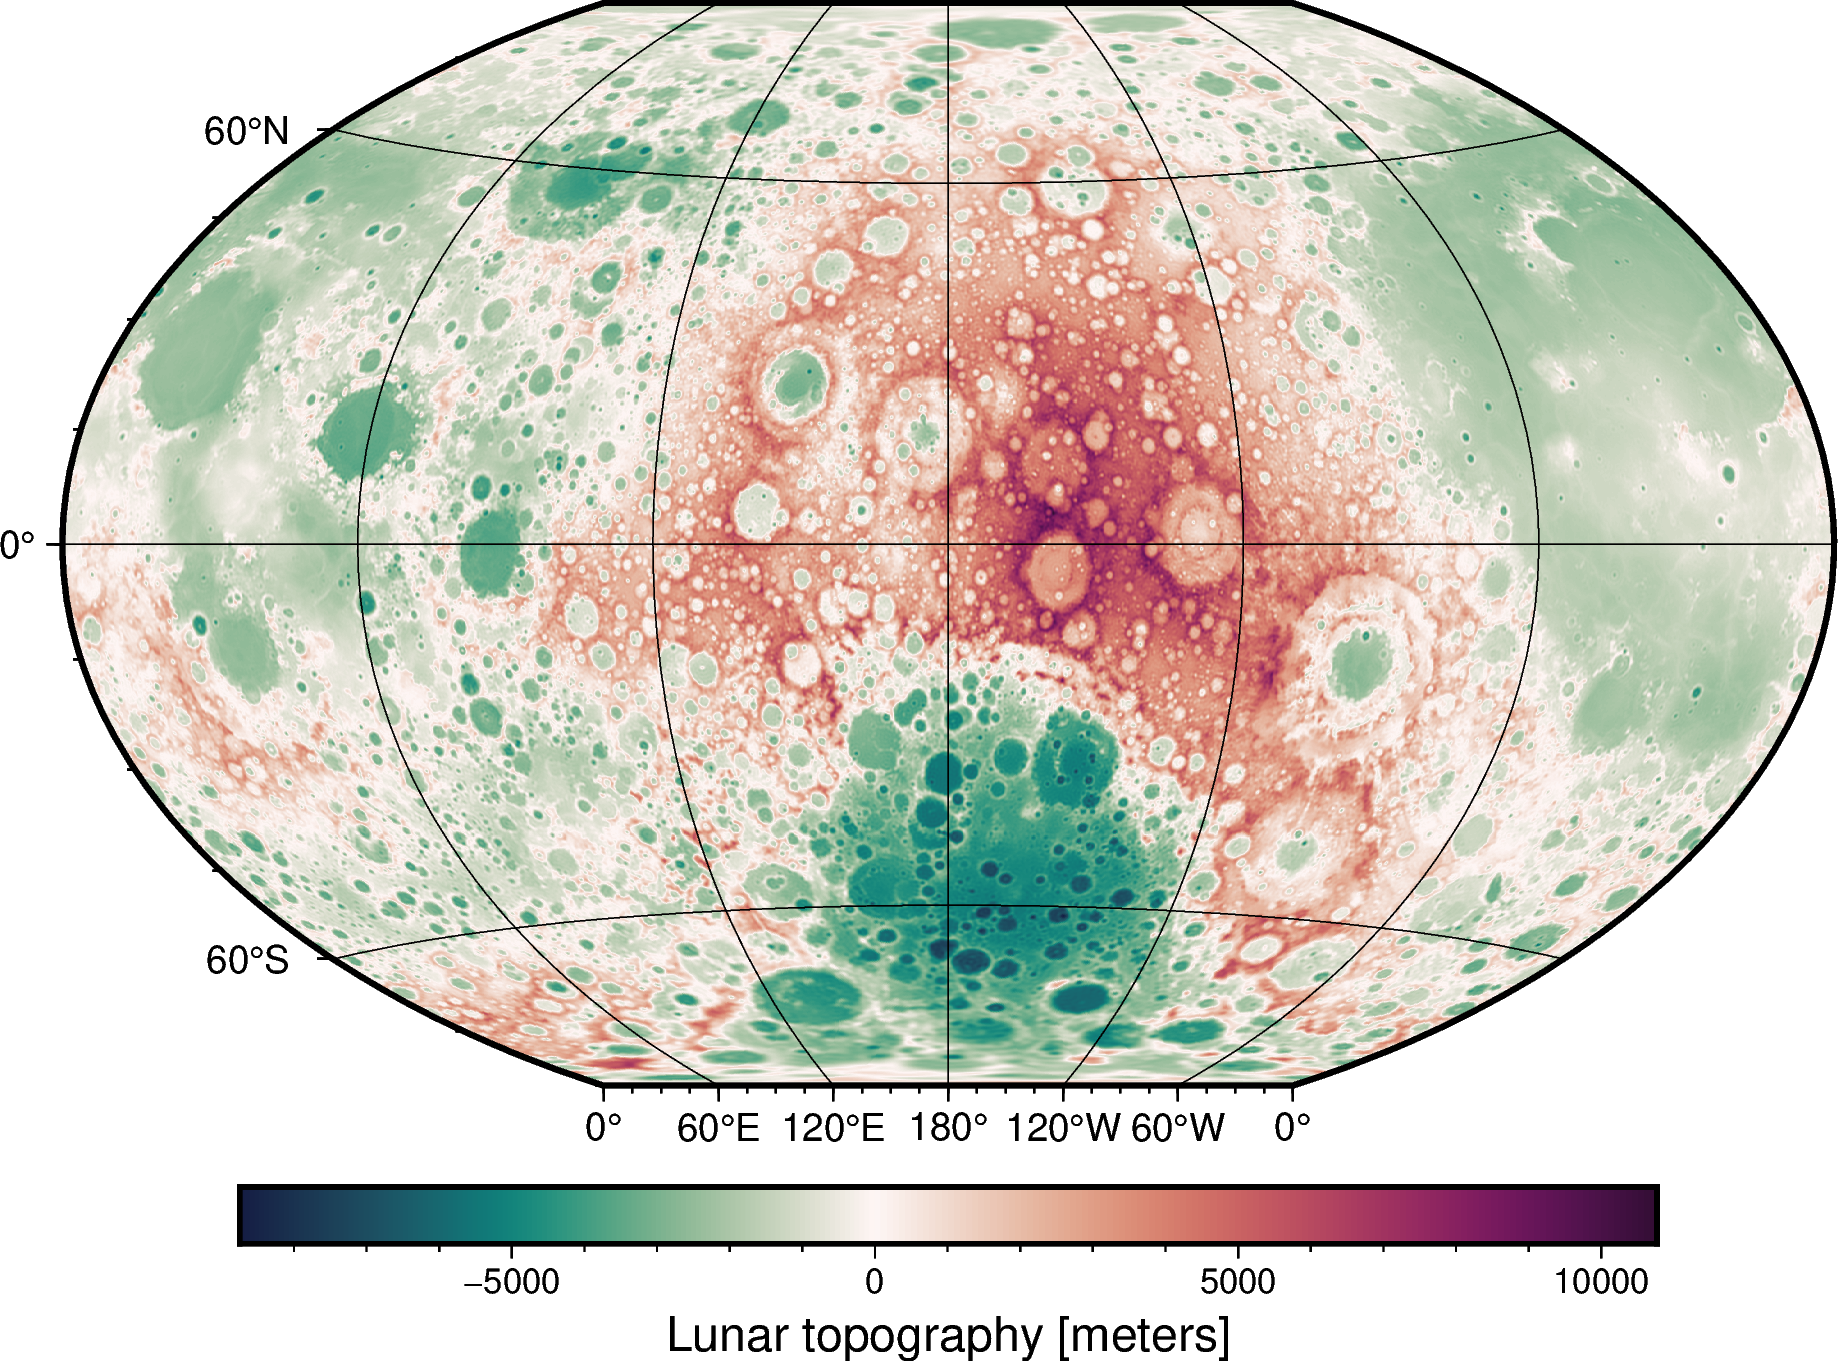

In [7]:
with pygmt.config(PROJ_ELLIPSOID=f"{bl.MOON.radius}f=0"):
    fig = pygmt.Figure()
    fig.grdimage(
        data,
        projection="R15c",
        cmap="curl+h",
        frame="afg",
    )
    fig.colorbar(frame='af+l"Lunar topography [meters]"')
    fig.savefig("preview.jpg")
    fig.show()

## Export

Save the grid to a netCDF file and calculate the size and MD5/SHA256 hashes.

Use compression (both zlib and discretization based) to reduce the file sizes. The scale_factor determines the amount of decimal places retained when converting floats into integers. See http://xarray.pydata.org/en/stable/user-guide/io.html#writing-encoded-data

In [8]:
output = "moon-topography-10arcmin.nc"
data.to_netcdf(
    output, 
    format="NETCDF4",
    encoding={
        'topography': {
            "zlib": True, 
            'dtype': 'int16', 
            'scale_factor': 1.0, 
            '_FillValue': 32000, 
            'add_offset': 0,
        },
    }
)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: moon-topography-10arcmin.nc
size: 3.042171 Mb
md5:0af3363529eb38bb8bbc144c5d756dd9
sha256:9190261690005fac8d63ed65133e7ab6f691b481a0bd6f52bcfb907b5dfadda2


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [9]:
data_reloaded = xr.load_dataarray(output)
data_reloaded

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)> Size: 9MB
array([[ 206.,  206.,  206., ...,  206.,  206.,  206.],
       [  -4.,   -5.,   -6., ...,   -1.,   -3.,   -4.],
       [-379., -381., -383., ..., -374., -376., -379.],
       ...,
       [ 384.,  387.,  390., ...,  378.,  381.,  384.],
       [ 602.,  603.,  604., ...,  600.,  601.,  602.],
       [ 238.,  238.,  238., ...,  238.,  238.,  238.]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 9kB 90.0 89.83 89.67 ... -89.67 -89.83 -90.0
  * longitude  (longitude) float64 17kB 0.0 0.1667 0.3333 ... 359.7 359.8 360.0
Attributes:
    Conventions:    CF-1.8
    title:          Topographic height of the Moon at 10 arc-minute resolution
    crs:            Lunar sphere with radius 1737151 m and 0 flattening
    source:         Generated from the spherical harmonic model of Wieczorek ...
    license:        CC-BY
    references:     https://doi.org/10.5281/zenodo.3870924
    long_name:      topographic height above the reference sphere
    standard_name:  height_above_reference_ellipsoid
    description:    height of topography referenced to the lunar spheroid
    units:          m
    actual_range:   [-8745. 10768.]
    max_degree:     539

Make the figure again but don't save it to a file this time.

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


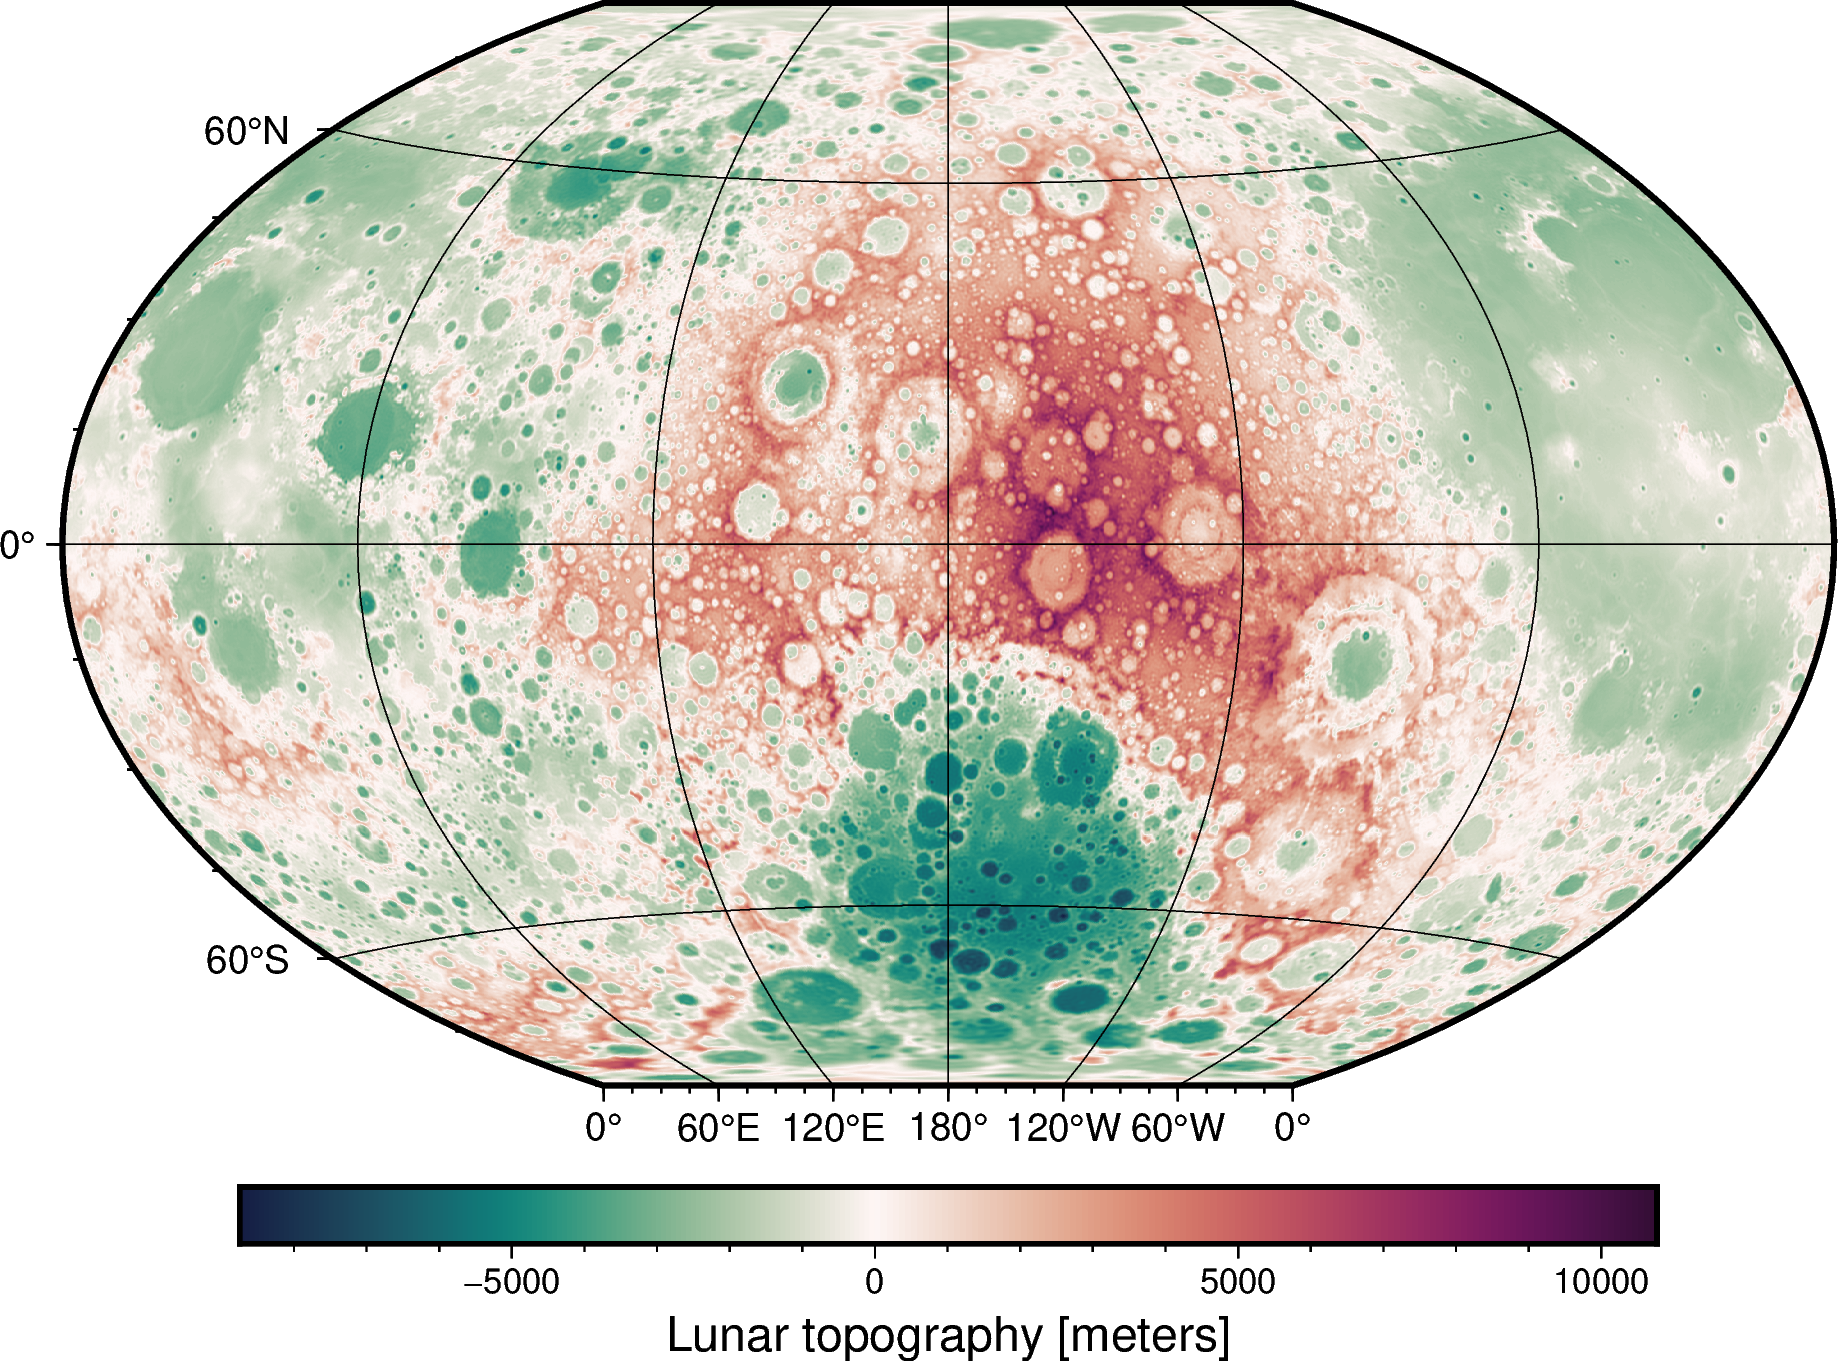

In [10]:
with pygmt.config(PROJ_ELLIPSOID=f"{bl.MOON.radius}f=0"):
    fig = pygmt.Figure()
    fig.grdimage(
        data,
        projection="R15c",
        cmap="curl+h",
        frame="afg",
    )
    fig.colorbar(frame='af+l"Lunar topography [meters]"')
    fig.show()